# Term Project Group 1


The Dataset: https://www.kaggle.com/datasets/waqi786/global-black-money-transactions-dataset

### Explanation:

This dataset gives a solid overview of black money transactions in different countries, focusing on financial activities tied to illegal dealings. It includes details like transaction amounts and risk scores, making it super useful for anyone looking to study financial crime trends or work on anti-money laundering tools.


### Dataset:

Transaction ID: Unique identifier for each transaction. (e.g., TX0000001)

Country: Country where the transaction occurred. (e.g., USA, China)

Amount (USD): Transaction amount in US Dollars. (e.g., 150000.00)

Transaction Type: Type of transaction. (e.g., Offshore Transfer, Property Purchase)

Date of Transaction: The date and time of the transaction. (e.g., 2022-03-15 14:32:00)

Person Involved: Name or identifier of the person/entity involved. (e.g., Person_1234)

Industry: Industry associated with the transaction. (e.g., Real Estate, Finance)

Destination Country: Country where the money was sent. (e.g., Switzerland)

Reported by Authority: Whether the transaction was reported to authorities. (e.g., True/False)

Source of Money: Origin of the money. (e.g., Legal, Illegal)

Money Laundering Risk Score: Risk score indicating the likelihood of money
laundering (1-10). (e.g., 8)

Shell Companies Involved: Number of shell companies used in the transaction. (e.g., 3)

Financial Institution: Bank or financial institution involved in the transaction. (e.g., Bank_567)

Tax Haven Country: Country where the money was transferred to a tax haven. (e.g., Cayman Islands)

# Pre-process and clean the dataset as appropriate.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
# from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel, chi2, SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


## Exploring the data

### Load Data

In [2]:
# Load data
df = pd.read_csv('Big_Black_Money_Dataset.csv')

In [5]:
# View the first few rows
df.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


In [7]:
# Check for missing values
df.isnull().sum()

Transaction ID                 0
Country                        0
Amount (USD)                   0
Transaction Type               0
Date of Transaction            0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
dtype: int64

In [9]:
# Get data types
df.dtypes

Transaction ID                  object
Country                         object
Amount (USD)                   float64
Transaction Type                object
Date of Transaction             object
Person Involved                 object
Industry                        object
Destination Country             object
Reported by Authority             bool
Source of Money                 object
Money Laundering Risk Score      int64
Shell Companies Involved         int64
Financial Institution           object
Tax Haven Country               object
dtype: object

In [11]:
df.describe()

,Amount (USD),Money Laundering Risk Score,Shell Companies Involved
count,1.000000e+04,10000.000000,10000.000000
mean,2.501818e+06,5.526400,4.469400
std,1.424364e+06,2.893603,2.879773
min,1.003180e+04,1.000000,0.000000
25%,1.279005e+06,3.000000,2.000000
50%,2.501310e+06,6.000000,4.000000
75%,3.722416e+06,8.000000,7.000000
max,4.999812e+06,10.000000,9.000000


## Processing the data

### Handle missing values if applicable

In [13]:
# For numerical features
numerical_features = ['Amount (USD)', 'Money Laundering Risk Score', 'Shell Companies Involved']
imputer = SimpleImputer(strategy='median')
df[numerical_features] = imputer.fit_transform(df[numerical_features])

# For categorical features
categorical_features = ['Country', 'Transaction Type', 'Person Involved', 'Industry',
                        'Destination Country', 'Financial Institution', 'Tax Haven Country']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

### Dropping Features and OHE

In [15]:
# Drop Irrelevant Features
df.drop('Transaction ID', axis=1, inplace=True) # Dropped because it is unique for each transaction
# df.drop('Person Involved', axis=1, inplace=True) # Frequency Encoding will be implemented
# df.drop('Financial Institution', axis=1, inplace=True) # Implement Frequency Encoding
df.drop('Date of Transaction', axis=1, inplace=True) # Date of transaction is not relevant

# Convert 'Reported by Authority' to integer
df['Reported by Authority'] = df['Reported by Authority'].astype(int)

# Frequency encoding for 'Financial Institution'
df['Financial Institution'] = df.groupby('Financial Institution')['Financial Institution'].transform('count')

# Frequency encoding for 'Person Involved'
df['Person Involved'] = df.groupby('Person Involved')['Person Involved'].transform('count')

# Encode target variable
le = LabelEncoder()
df['Source of Money'] = le.fit_transform(df['Source of Money'])

# One-Hot Encode nominal categorical features
nominal_features = ['Country', 'Transaction Type', 'Industry',
                    'Destination Country', 'Tax Haven Country']
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

dummy_columns = df.filter(like='_').columns
df[dummy_columns] = df[dummy_columns].astype(int)



In [17]:
df.columns

Index(['Amount (USD)', 'Person Involved', 'Reported by Authority',
       'Source of Money', 'Money Laundering Risk Score',
       'Shell Companies Involved', 'Financial Institution', 'Country_China',
       'Country_India', 'Country_Russia', 'Country_Singapore',
       'Country_South Africa', 'Country_Switzerland', 'Country_UAE',
       'Country_UK', 'Country_USA', 'Transaction Type_Cryptocurrency',
       'Transaction Type_Offshore Transfer',
       'Transaction Type_Property Purchase',
       'Transaction Type_Stocks Transfer', 'Industry_Casinos',
       'Industry_Construction', 'Industry_Finance', 'Industry_Luxury Goods',
       'Industry_Oil & Gas', 'Industry_Real Estate',
       'Destination Country_China', 'Destination Country_India',
       'Destination Country_Russia', 'Destination Country_Singapore',
       'Destination Country_South Africa', 'Destination Country_Switzerland',
       'Destination Country_UAE', 'Destination Country_UK',
       'Destination Country_USA', 'Tax H

In [19]:
df.head()

,Amount (USD),Person Involved,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Country_China,Country_India,Country_Russia,...,Destination Country_South Africa,Destination Country_Switzerland,Destination Country_UAE,Destination Country_UK,Destination Country_USA,Tax Haven Country_Cayman Islands,Tax Haven Country_Luxembourg,Tax Haven Country_Panama,Tax Haven Country_Singapore,Tax Haven Country_Switzerland
0,3.267530e+06,2,1,0,6.0,1.0,17,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,4.965767e+06,1,0,0,9.0,0.0,24,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9.416750e+04,1,1,0,1.0,3.0,12,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,3.864201e+05,5,0,0,7.0,2.0,18,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6.433784e+05,4,1,0,1.0,9.0,19,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [21]:
df['Source of Money'].value_counts()

Source of Money
0    7017
1    2983
Name: count, dtype: int64

In [23]:
features_to_modify = ['Amount (USD)', 'Money Laundering Risk Score', 'Shell Companies Involved']

def scale_features(df, features):
    df_S = df.copy()
    scaler = StandardScaler()
    df_S[features] = scaler.fit_transform(df[features])
    return df_S

def normalize_features(df, features):
    df_N = df.copy()
    scaler = MinMaxScaler()
    df_N[features] = scaler.fit_transform(df[features])
    return df_N



### Biased data correction

In [25]:
def Undersampling(X,Y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state=0)
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

## Feature Selectors (Optional):

### Feature selector functions

In [27]:
def cor_selector(X, y,num_feats):
    # Your code goes here (Multiple lines)
    cor_list = []
    feature_name = X.columns.tolist()
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    #print(np.argsort(np.abs(cor_list)))
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    #print(cor_feature)
    cor_support = [True if i in cor_feature else False for i in feature_name]
    # Your code ends here
    return cor_support, cor_feature

def chi_squared_selector(X, y, num_feats):
    # Your code goes here (Multiple lines)
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    #print(chi_support)
    chi_feature = X.loc[:,chi_support].columns.tolist()
    # Your code ends here
    return chi_support, chi_feature

def rfe_selector(X, y, num_feats):
    # Your code goes here (Multiple lines)
    rfe_selector = RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.support_
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    # Your code ends here
    return rfe_support, rfe_feature

def embedded_log_reg_selector(X, y, num_feats):
    # Your code goes here (Multiple lines)
    embedded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", random_state = 42), max_features=num_feats)
    embedded_lr_selector.fit(X, y)
    embedded_lr_support = embedded_lr_selector.get_support()
    embedded_lr_feature = X.loc[:,embedded_lr_support].columns.tolist()
    # Your code ends here
    return embedded_lr_support, embedded_lr_feature

def embedded_rf_selector(X, y, num_feats):
    # Your code goes here (Multiple lines)
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embedded_rf_support = embeded_rf_selector.get_support()
    embedded_rf_feature = X.loc[:,embedded_rf_support].columns.tolist()
    # Your code ends here
    return embedded_rf_support, embedded_rf_feature

def embedded_lgbm_selector(X, y, num_feats):
    # Your code goes here (Multiple lines)
    lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgbm_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgbm_selector.fit(X, y)
    embedded_lgbm_support = embeded_lgbm_selector.get_support()
    embedded_lgbm_feature = X.loc[:,embedded_lgbm_support].columns.tolist()
    # Your code ends here
    return embedded_lgbm_support, embedded_lgbm_feature

### Feature Selectors Combined:

In [29]:
def autoFeatureSelector(X, y, num_feats, methods=[]):

    support_dict = {}

    feature_name = list(X.columns)
    support_dict['Feature'] = feature_name
    
    if 'pearson' in methods:
        cor_support, cor_feature = cor_selector(X, y, num_feats)
        support_dict['Pearson'] = cor_support
    if 'chi-square' in methods:
        chi_support, chi_feature = chi_squared_selector(X, y, num_feats)
        support_dict['Chi-2'] = chi_support
    if 'rfe' in methods:
        rfe_support, rfe_feature = rfe_selector(X, y, num_feats)
        support_dict['RFE'] = rfe_support
    if 'log-reg' in methods:
        embedded_lr_support, embedded_lr_feature = embedded_log_reg_selector(X, y, num_feats)
        support_dict['Logistics'] = embedded_lr_support
    if 'rf' in methods:
        embedded_rf_support, embedded_rf_feature = embedded_rf_selector(X, y, num_feats)
        support_dict['Random Forest'] = embedded_rf_support
    if 'lgbm' in methods:
        embedded_lgbm_support, embedded_lgbm_feature = embedded_lgbm_selector(X, y, num_feats)
        support_dict['LightGBM'] = embedded_lgbm_support 
    
    # Combine all the above feature list and count the maximum set of features that got selected by all methods
    
    print("Combining all methods")
    feature_selection_df = pd.DataFrame(support_dict)
    feature_selection_df['Total'] = feature_selection_df.apply(lambda row: np.sum(row[1:].astype(int)), axis=1)
    print("Sorting features")
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    print("Selecting best features")
    best_features = feature_selection_df['Feature'].tolist()[:num_feats]
    return best_features, feature_selection_df

# Models:

- Utilize GridSearchCV to tune the parameters of each of the models.
- Check if better results can be obtained for any of the models.
- Discuss your observations regarding model performance.
- Randomly remove some features (or based on a certain hypothesis) and re-evaluate the models.
- Document your observations concerning model performances.

## Logistic Regression: Saif, Dwip


### Data for LR

In [25]:
# Get the data for Logistic Regression
df_LR = df.copy()

# Normalize the variables that are greater than 1 as this will affect the models proformnce
df_LR = normalize_features(df_LR, ['Amount (USD)', 'Money Laundering Risk Score', 'Shell Companies Involved', 'Financial Institution', 'Person Involved'])

df_LR.columns

Index(['Amount (USD)', 'Person Involved', 'Reported by Authority',
       'Source of Money', 'Money Laundering Risk Score',
       'Shell Companies Involved', 'Financial Institution', 'Country_China',
       'Country_India', 'Country_Russia', 'Country_Singapore',
       'Country_South Africa', 'Country_Switzerland', 'Country_UAE',
       'Country_UK', 'Country_USA', 'Transaction Type_Cryptocurrency',
       'Transaction Type_Offshore Transfer',
       'Transaction Type_Property Purchase',
       'Transaction Type_Stocks Transfer', 'Industry_Casinos',
       'Industry_Construction', 'Industry_Finance', 'Industry_Luxury Goods',
       'Industry_Oil & Gas', 'Industry_Real Estate',
       'Destination Country_China', 'Destination Country_India',
       'Destination Country_Russia', 'Destination Country_Singapore',
       'Destination Country_South Africa', 'Destination Country_Switzerland',
       'Destination Country_UAE', 'Destination Country_UK',
       'Destination Country_USA', 'Tax H

### Simple LR Model

In [27]:
# Implement a logistic regression model
X = df_LR.drop('Source of Money', axis=1)
Y = df_LR['Source of Money']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Fit the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Logistic Regression
[[1406    0]
 [ 594    0]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1406
           1       0.00      0.00      0.00       594

    accuracy                           0.70      2000
   macro avg       0.35      0.50      0.41      2000
weighted avg       0.49      0.70      0.58      2000

0.703


C:\Users\mooss\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mooss\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mooss\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Using Undersampling to train the LR Model:

In [73]:
X_train, X_test, y_train, y_test = Undersampling(X, Y, 0.2)

# Fit the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Logistic Regression
[[696 710]
 [298 296]]
              precision    recall  f1-score   support

           0       0.70      0.50      0.58      1406
           1       0.29      0.50      0.37       594

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.47      2000
weighted avg       0.58      0.50      0.52      2000

0.496


### GridSearchCV LR

In [74]:
# Define the hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100, 1000]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
# Get the best model
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


{'C': 10, 'penalty': 'l2'}
0.4886989857390085
LogisticRegression(C=10)
Logistic Regression
[[698 708]
 [296 298]]
              precision    recall  f1-score   support

           0       0.70      0.50      0.58      1406
           1       0.30      0.50      0.37       594

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.48      2000
weighted avg       0.58      0.50      0.52      2000

0.498


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _

#### Modifying features and testing proformance

In [90]:
df_LR_Mod = df_LR.copy()

# Remove the features that are not important
df_LR_Mod = df_LR_Mod.drop(['Person Involved', 'Financial Institution'], axis=1)

X = df_LR_Mod.drop('Source of Money', axis=1)
Y = df_LR_Mod['Source of Money']

X_train, X_test, y_train, y_test = Undersampling(X, Y, 0.3)

# Define the hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100, 1000]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
# Get the best model
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

{'C': 0.01, 'penalty': 'l2'}
0.5002383749247915
LogisticRegression(C=0.01, max_iter=1000)
Logistic Regression
[[1030 1075]
 [ 460  435]]
              precision    recall  f1-score   support

           0       0.69      0.49      0.57      2105
           1       0.29      0.49      0.36       895

    accuracy                           0.49      3000
   macro avg       0.49      0.49      0.47      3000
weighted avg       0.57      0.49      0.51      3000

0.48833333333333334


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _

## Decision Tree: Nitish, Sehaj

### Data for DT Model

In [76]:
df_DT = df.copy()
# Drop person involved
df_DT.drop('Person Involved', axis=1, inplace=True)

### DT Model

In [77]:
# Splitting the data into features (X) and target (y)
X = df_DT.drop('Source of Money', axis=1)
y = df_DT['Source of Money']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training using RandomForestClassifier
clf = DecisionTreeClassifier(random_state=42, max_depth=10) # Changed
clf.fit(X_train, y_train)

# Predictions and accuracy score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.6715


In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1307   82]
 [ 575   36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.80      1389
           1       0.31      0.06      0.10       611

    accuracy                           0.67      2000
   macro avg       0.50      0.50      0.45      2000
weighted avg       0.58      0.67      0.59      2000



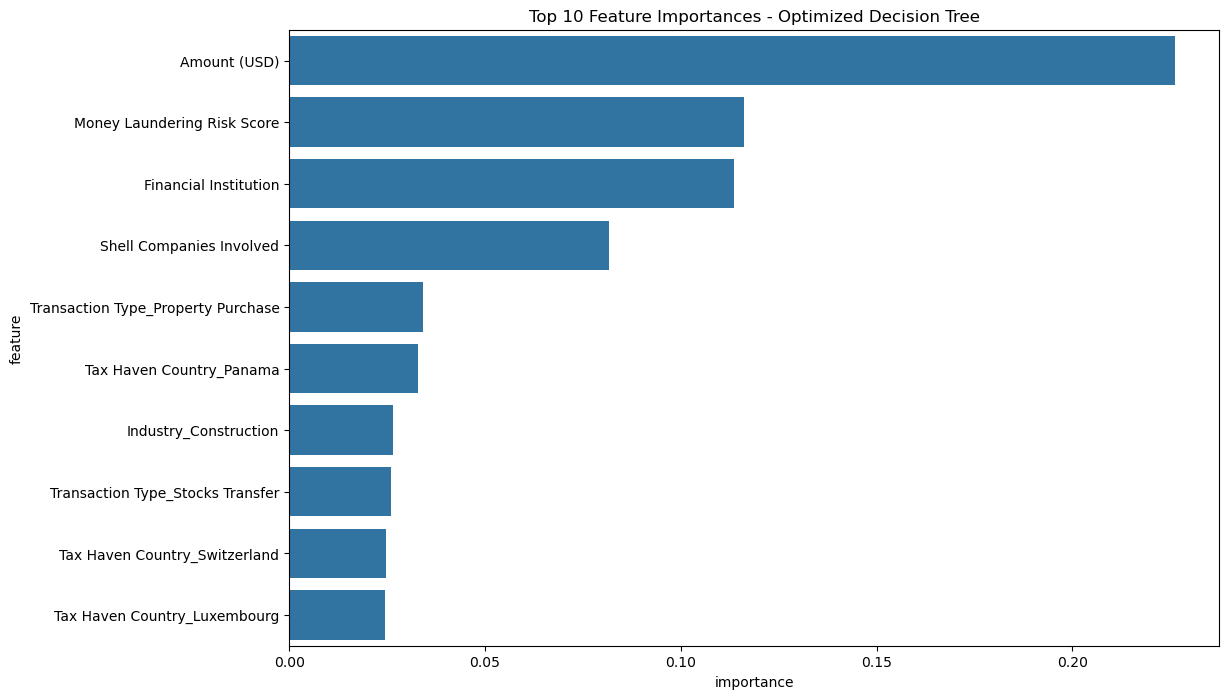

In [79]:
feature_importances = clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Get top 10 features
top_features = importance_df.sort_values(by='importance', ascending=False).head(10)

#
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 10 Feature Importances - Optimized Decision Tree')
plt.show()

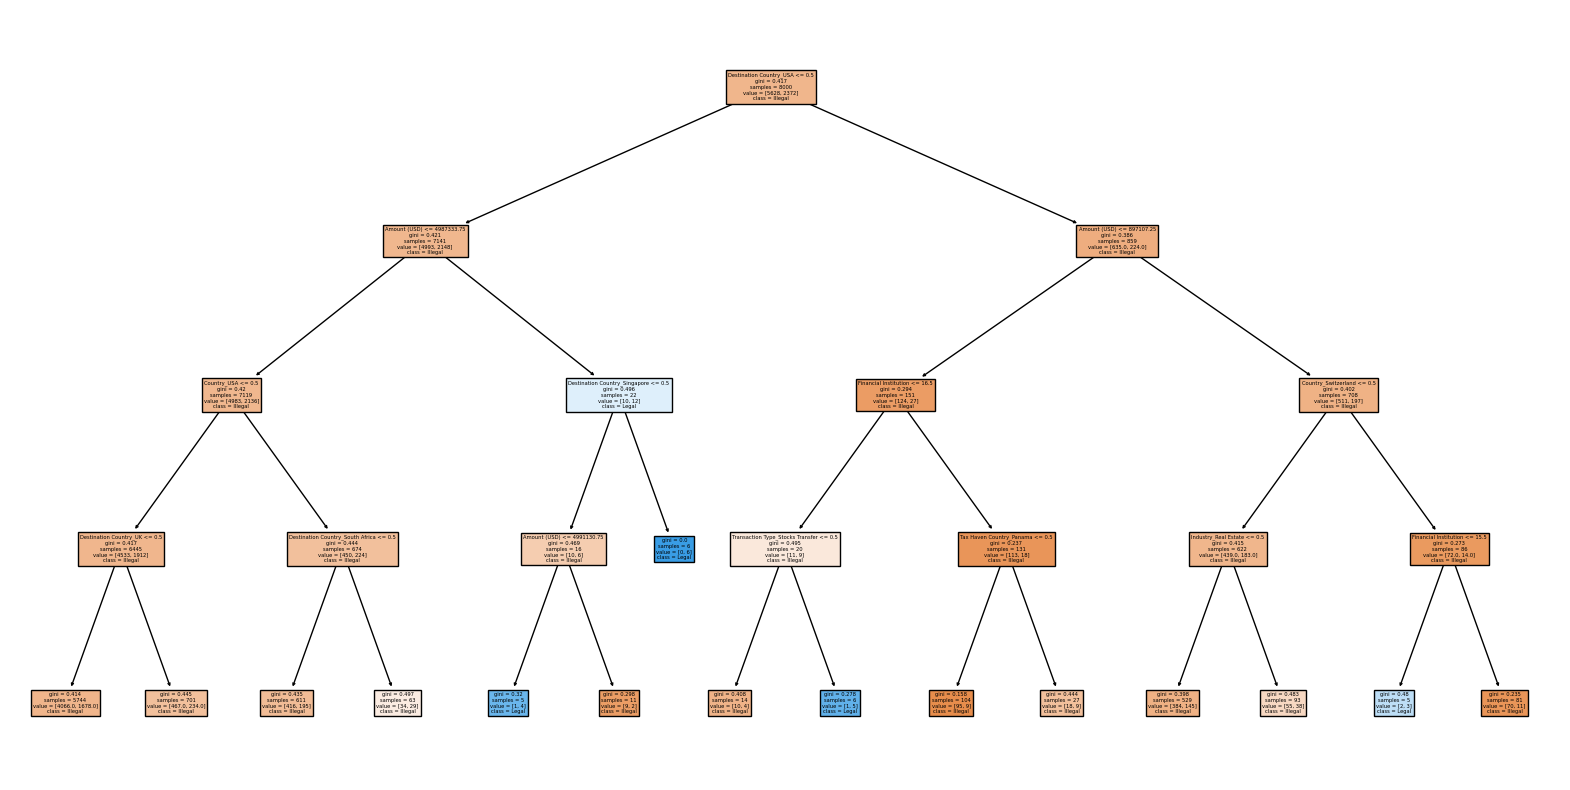

In [80]:
# Fit a single decision tree to visualize
tree_clf = DecisionTreeClassifier(max_depth=4)  # Limit depth for clarity
tree_clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=X.columns, class_names=['Illegal', 'Legal'], filled=True)
plt.show()

## Random Forest: Egor, Ash

### Data for RF Model

In [81]:
# Get the data for RF model
df_RF = df.copy()

### This needs to be reviewed RF X and Y???

In [82]:
# Define features (X) and target (y) - binary classification on 'Money Laundering Risk Score'
X_new = df_RF.drop(columns=['Money Laundering Risk Score'])
y_new = (df_RF['Money Laundering Risk Score'] >= 5).astype(int)  # Binary target: 1 if score >= 5, else 0

# Split the dataset into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# Initialize and train the RandomForest classifier
rf_clf_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_new.fit(X_train_new, y_train_new)

# Make predictions on the test set
y_pred_new = rf_clf_new.predict(X_test_new)

# Generate the confusion matrix and classification report
conf_matrix_new = confusion_matrix(y_test_new, y_pred_new)
class_report_new = classification_report(y_test_new, y_pred_new)

# Display the results
print("Confusion Matrix:")
print(conf_matrix_new)
print("\nClassification Report:")
print(class_report_new)

Confusion Matrix:
[[ 191 1058]
 [ 254 1497]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.15      0.23      1249
           1       0.59      0.85      0.70      1751

    accuracy                           0.56      3000
   macro avg       0.51      0.50      0.46      3000
weighted avg       0.52      0.56      0.50      3000



In [83]:
# Split the dataset into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# Define a simplified parameter grid for GridSearchCV
simple_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the RandomForest model
rf_clf_simplified = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
simple_grid_search = GridSearchCV(estimator=rf_clf_simplified,
                                  param_grid=simple_param_grid,
                                  cv=3,  # 3-fold cross-validation
                                  verbose=1,
                                  n_jobs=-1)

# Fit the simplified grid search model
simple_grid_search.fit(X_train_new, y_train_new)

# Best hyperparameters from the grid search
best_params_simplified = simple_grid_search.best_params_

# Train the best model on the training set
best_rf_model_simplified = simple_grid_search.best_estimator_
best_rf_model_simplified.fit(X_train_new, y_train_new)

# Make predictions with the tuned model
y_pred_tuned_simplified = best_rf_model_simplified.predict(X_test_new)

# Generate confusion matrix and classification report for the tuned model
conf_matrix_tuned_simplified = confusion_matrix(y_test_new, y_pred_tuned_simplified)
class_report_tuned_simplified = classification_report(y_test_new, y_pred_tuned_simplified)

# Output best parameters, confusion matrix, and classification report
print("Best Hyperparameters:", best_params_simplified)
print("Confusion Matrix:\n", conf_matrix_tuned_simplified)
print("Classification Report:\n", class_report_tuned_simplified)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


KeyboardInterrupt: 

## SGD: Devanshi, James, Abraham

In [44]:
# Stochastic Gradient Descent

## SVM: Eric, Moosa

### Data for SVM

In [31]:
df_svm = df.copy()

In [33]:
X = df_svm.drop(columns=['Source of Money'])
y = df_svm['Source of Money']

### Splitting the data for training and testing

In [35]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### SVM Model Training and Prediction

In [47]:
svc_model = SVC(kernel='poly', class_weight='balanced')
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(f"SVC Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred,  zero_division=1))

[[1672  433]
 [ 711  184]]
SVC Accuracy: 0.6187
              precision    recall  f1-score   support

           0       0.70      0.79      0.75      2105
           1       0.30      0.21      0.24       895

    accuracy                           0.62      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.58      0.62      0.60      3000



### GridSearchCV (Hyper Parameter tuning)

In [39]:
# Hyperparameter Tuning using GridSearchCV
# SVM GridSearchCV params
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['poly']
}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
print(f"Best SVM Parameters: {grid_svm.best_params_}")
print(f"Best SVM Accuracy: {grid_svm.best_score_}")

Best SVM Parameters: {'C': 0.1, 'kernel': 'poly'}
Best SVM Accuracy: 0.7017142857142857


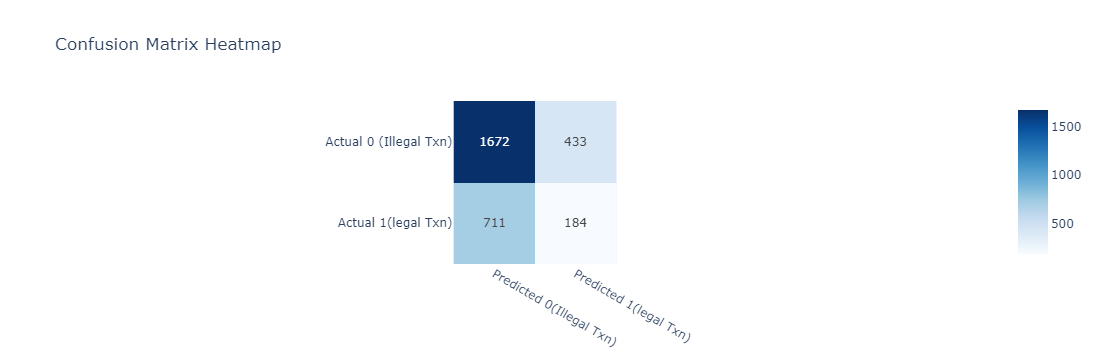

In [43]:
import plotly.express as px
import pandas as pd

# Confusion matrix values
conf_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual 0 (Illegal Txn)', 'Actual 1(legal Txn)'], columns=['Predicted 0(Illegal Txn)', 'Predicted 1(legal Txn)'])

# Confusion Matrix Heatmap
fig = px.imshow(conf_df, text_auto=True, color_continuous_scale='Blues', title='Confusion Matrix Heatmap')
fig.show()

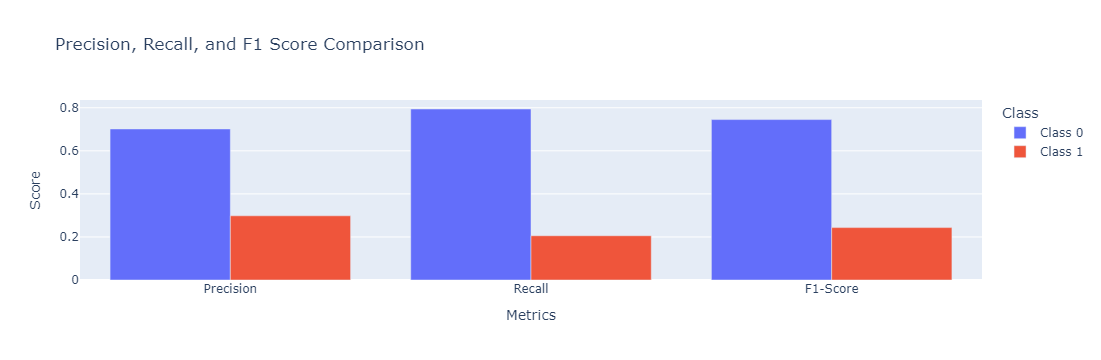

In [53]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

# Extract precision, recall, and f1-score for both classes
metrics_data = {
    "Metrics": ["Precision", "Recall", "F1-Score"],
    "Class 0": [report['0']['precision'], report['0']['recall'], report['0']['f1-score']],
    "Class 1": [report['1']['precision'], report['1']['recall'], report['1']['f1-score']]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Bar Chart for Precision, Recall, F1 Score
fig = px.bar(df_metrics, x="Metrics", y=["Class 0", "Class 1"], barmode="group",
             title="Precision, Recall, and F1 Score Comparison",
             labels={"value": "Score", "variable": "Class"})
fig.show()

# Conclusion and comparison


Present your work including approach and findings during the class on September 24th or 26th, 2024. Each group will have a maximum of 15 minutes to present their project. It is advised that your PowerPoint files to be no longer than 15 slides.

Prepare a written technical report of no longer than 15 pages to discuss the problem statement, various steps conducted, summary of findings and conclusions. Submit the report and the notebook file (with proper headings, explanatory comments and code sections) by the midnight of September 29th, 2024.